# LXDR class details

**Class LXDR(dimensionality_reduction_model, feature_names, initial_data)**

**Parameters:**

*   **dimensionality_reduction_model:** model used to dimensionally reduce the data (should be fitted on the initial dataset prior the object creation).
*   **feature_names:** The names of the dataset columns.
*   **scope:** If the techinque will work locally or globally. Accepted values 'local', or 'global'
*   **initial_data:** 2d array contaning the orgina dataset
*   **neural:** if the DR is an AutoEncoder (True or False)
*   **mean:** 1d array containing the mean values of features. if mean isn't defiend we set a zero array to its place. This is going to be used during the training of the local models

**Methods**


*   **explain_instance(instance, number_of_neghbours, auto_alpha, use_LIME)** Provides us with the weights needed for the explanations.


*   **find_reconstruction_error(data, number_of_neighbours, auto_alpha, use_LIME)** Prints mean absolute error, cosine error, euclidean error between the reduced data extracted through LXDR and the dimensionality reduction technique.


*   **find_weights_error(data, number_of_neighbours, auto_alpha, use_LIME)** This function only works when the dimensionality reduction technique is able to return weights per each component. Prints mean absolute error, cosine error, euclidean error between the weigths created through LXDR, and weights extracted through the dimensionality reduction technique.

*   **visualise_weights(instance, dimension, number_of_neighbours,auto_alpha, use_LIM)** This function only works when the dimensionality reduction technique is able to return weights per each component. Creates a plot that compares weights extracted from LXDR and the dimensionality reduction technique, of a particular dimension of the instance.


*   **visualise_reconstructed(instance, number_of_neighbours, auto_alpha, use_LIME)** Reconstructs the dimensionally reduced data throught the weights extracted from LXDR, and compares them with the dimensionally reduced data given from the dimensionality reduction technique for a particular instance.

*   **create_heatmap(instance, number_of_neighbours, auto_alpha, use_LIME)** Plots a Heatmap showing the difference between weigths extracted through LXDR and weigths extracted from the dimensionality reduction technique, for a particular instance.

*   **get_feature_importance(instance, number_of_neighbours, auto_alpha, use_LIME)** Creates and prints an array shaped (N_features, N_reduced_features) where for each reduced features, highlights the original feature that contributed the most to its creation.

# Code Example

## Imports

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

## Lime installation

In [2]:
!pip install lime==0.2.0.1

     |████████████████████████████████| 275 kB 4.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9a882eb43a88cf712619e605722ecaac3b0a6b20597d82e80e3a6f5c95903a38
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


## lime_tabular

In order to take advantage of LIME neighborhood generation, lime_tabular.py shall be moved into lime's file directory. This can be done by running the code bellow.

In [3]:
!mv lime_tabular.py /usr/local/lib/python3.7/dist-packages/lime/

## Load the dataset

For this example we will use the diabetes dataset and PCA as a dimensionality reduction technique. Since PCA is interpretable, it will give us the ability to compare the results of LXDR with the ground truth.

In [4]:
#Load data
diabetes = datasets.load_diabetes()
initial_data = diabetes.data
initial_predictions = diabetes.target
feature_names = diabetes.feature_names

#train_test_split the data (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
     initial_data, initial_predictions, test_size=0.2, random_state=42)

# initialize and fit PCA
pca = PCA(n_components=8)
pca.fit(initial_data)
mean = initial_data.mean(axis=0)

#reduce dimensions from 10 to 8 on both train and test sets
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

X_test_reduced[1]

array([-0.01830892, -0.00379885,  0.08204992,  0.00632399, -0.06140154,
       -0.06166935, -0.02689931, -0.01348123])

Above we can see the reduced representation of the first instance of the test set. The dimensions were reduced from 10 to 8 (components). Since PCA is interpretable, it provides us with weights that can be utilized in order to find out which of the original features contributed the most for the creation of each component.

Nevertheless, this is not always the case, since most of DR techniques do not provide such information. This is why a technique like LXDR is needed in order to provide this kind of interpretations.

In the rest of this notebook we will have a look on how LXDR and its methos can be applied to solve the interpretability issue.

## Introducing LXDR

Lets create an object of LXDR class, and give it pca as dimensionality reduction technique, as well as the dataset and the features names of the dataset (everything was defined in the previous cell)

For the cells below, we will use for simplicity the parameters (number_of_neighbours=50, auto_alpha=True, use_LIME=True). 

These parameter values work well in most cases, although parameter tuning is suggested for potentially better results depending on the dataset.



In [5]:
from lxdr import LXDR
lxdr_obj = LXDR(pca, feature_names, 'local', initial_data, False, mean)

## Feature Importance

In the table below, LXDR provides us with the amount of influence each feature had for the generation of the reduced space data. Each column represents one of the 8 components and each row represents one of the 10 features. Each highlighted cell tells us which feature contributed the most. 

For example the highlighted cell (0,0) tells us that the first feature was the one that contributed the most on the fisrt component.

In [6]:
lxdr_obj.get_feature_importance(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True)

,0,1,2,3,4,5,6,7
0,0.020033,0.004106,0.045788,0.038321,0.063577,0.020905,0.010139,0.001382
1,0.008346,0.017255,0.004771,0.030349,0.016671,0.001863,0.003017,0.019773
2,0.011188,0.005767,0.006183,0.018446,0.004774,0.014878,0.019186,0.014502
3,0.005943,0.003024,0.011233,0.000430,0.010649,0.005966,0.007013,0.010441
4,0.008567,0.014302,0.001712,0.001707,0.003224,0.000135,0.001838,0.003230
5,0.005861,0.007595,0.004492,0.002795,0.001945,0.002220,0.003840,0.003187
6,0.000220,0.000394,0.000301,0.000059,0.000191,0.000083,0.000006,0.000253
7,0.016936,0.002693,0.015034,0.000313,0.005673,0.001341,0.002813,0.007132
8,0.008523,0.000590,0.001433,0.005953,0.003414,0.004024,0.014572,0.010123
9,0.007020,0.001851,0.006032,0.001898,0.000684,0.017540,0.007784,0.003630


But how can we be sure that these results are accurate?

On the rest of the notebook we will provide comparisons between LXDR and PCA.

## Weight Comparison

First, lets compare the weights created by LXDR to the weights that PCA provides us.

In [8]:
print("Weights of LXDR")
display(pd.DataFrame(lxdr_obj.explain_instance(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True)))

print("")
print("Weights of PCA")
display(pd.DataFrame(pca.components_))

Weights of LXDR


,0,1,2,3,4,5,6,7,8,9
0,0.216425,0.186970,0.303153,0.271731,0.343240,0.351861,-0.282421,0.428823,0.378607,0.322171
1,0.044376,-0.386537,-0.156276,-0.138248,0.573009,0.455922,0.506215,-0.068185,-0.026187,-0.084947
2,0.494657,-0.106853,0.167528,0.513558,-0.068582,-0.269691,0.386023,-0.380676,0.063629,0.276833
3,-0.414004,-0.679841,0.499807,-0.019664,-0.068401,-0.167765,-0.076016,0.007916,0.264419,0.087077
4,-0.686849,0.373446,0.129360,0.486884,0.129170,0.116726,0.244980,-0.143643,-0.151653,0.031390
5,-0.225845,0.041736,-0.403131,-0.272760,0.005404,-0.133255,0.106370,-0.033944,0.178725,0.805044
6,-0.109539,-0.067607,-0.519844,0.320643,0.073649,-0.230534,-0.007531,0.071232,0.647301,-0.357268
7,0.014937,0.442929,0.392927,-0.477348,0.129410,-0.191306,0.324622,-0.180586,0.449651,-0.166598



Weights of PCA


,0,1,2,3,4,5,6,7,8,9
0,0.216431,0.186967,0.303162,0.271740,0.343255,0.351861,-0.282436,0.428833,0.378617,0.322183
1,0.044372,-0.386548,-0.156281,-0.138256,0.573027,0.455940,0.506243,-0.068184,-0.026189,-0.084947
2,0.494668,-0.106858,0.167532,0.513568,-0.068587,-0.269694,0.386028,-0.380681,0.063632,0.276843
3,-0.414009,-0.679861,0.499825,-0.019667,-0.068395,-0.167774,-0.076020,0.007921,0.264427,0.087086
4,-0.686864,0.373456,0.129359,0.486890,0.129174,0.116731,0.244991,-0.143644,-0.151661,0.031388
5,-0.225851,0.041731,-0.403142,-0.272763,0.005409,-0.133257,0.106372,-0.033945,0.178730,0.805064
6,-0.109538,-0.067606,-0.519858,0.320649,0.073649,-0.230540,-0.007534,0.071236,0.647313,-0.357273
7,0.014935,0.442940,0.392942,-0.477364,0.129414,-0.191311,0.324636,-0.180588,0.449660,-0.166609


As we can see above, LXDR was able to generate very similar weights. It is worthy mentioning that LXDR creates a set of weights for each individual instance, while PCA has only one set of weights for the entire dataset.

A more intuitive comparison of the weights for the same instance can be seen in the heatmap below.


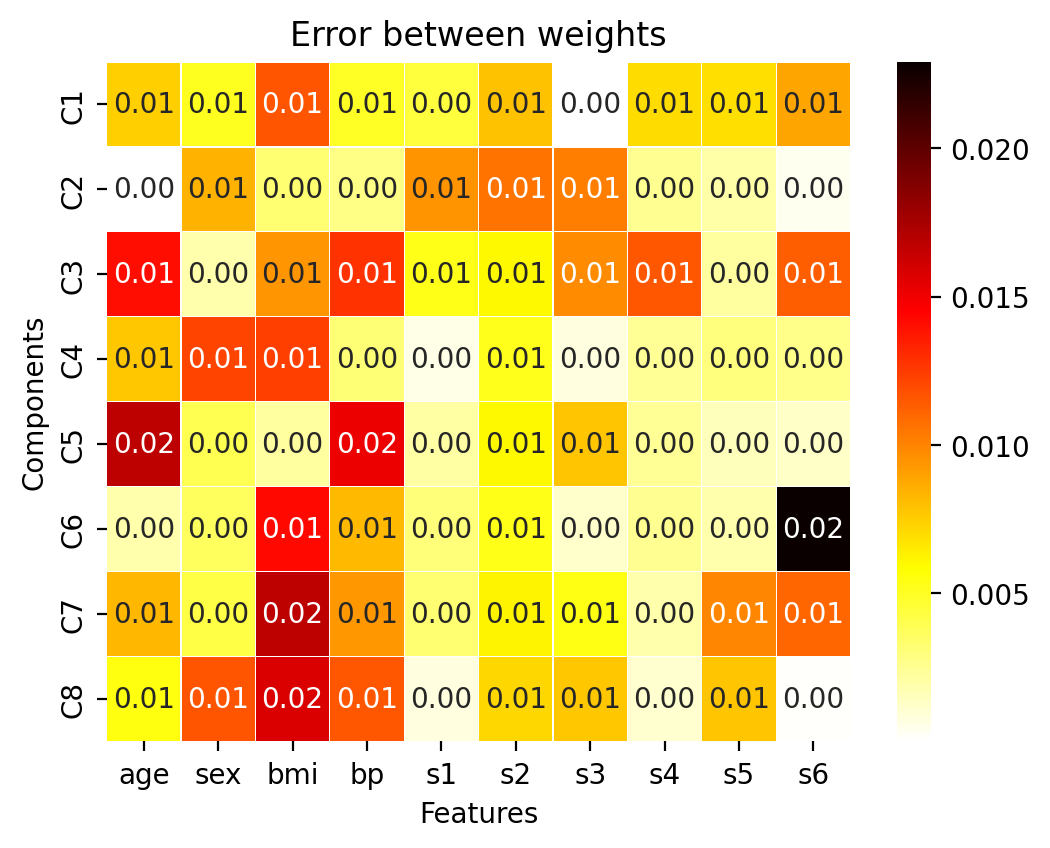

In [9]:
lxdr_obj.create_heatmap(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True)

Lets also calculate the error between the weights of LXDR and PCA for the whole dataset. Below we can see the Mean Absolute Error, the Cosine Error and the Euclidean error.

In [10]:
print(lxdr_obj.find_weights_error(X_test, number_of_neighbours=50, auto_alpha=True, use_LIME=True))

mean_absolute_error =  7.3016214118327955e-06
cosine error =  7.890614363526753e-11
euclidean error =  2.8438684920474243e-05
(7.3016214118327955e-06, 7.890614363526753e-11, 2.8438684920474243e-05)


## Instance difference

Below we can see the comparison between the reduced space instance generated via the weights of LXDR and the weights of DRt (PCA).

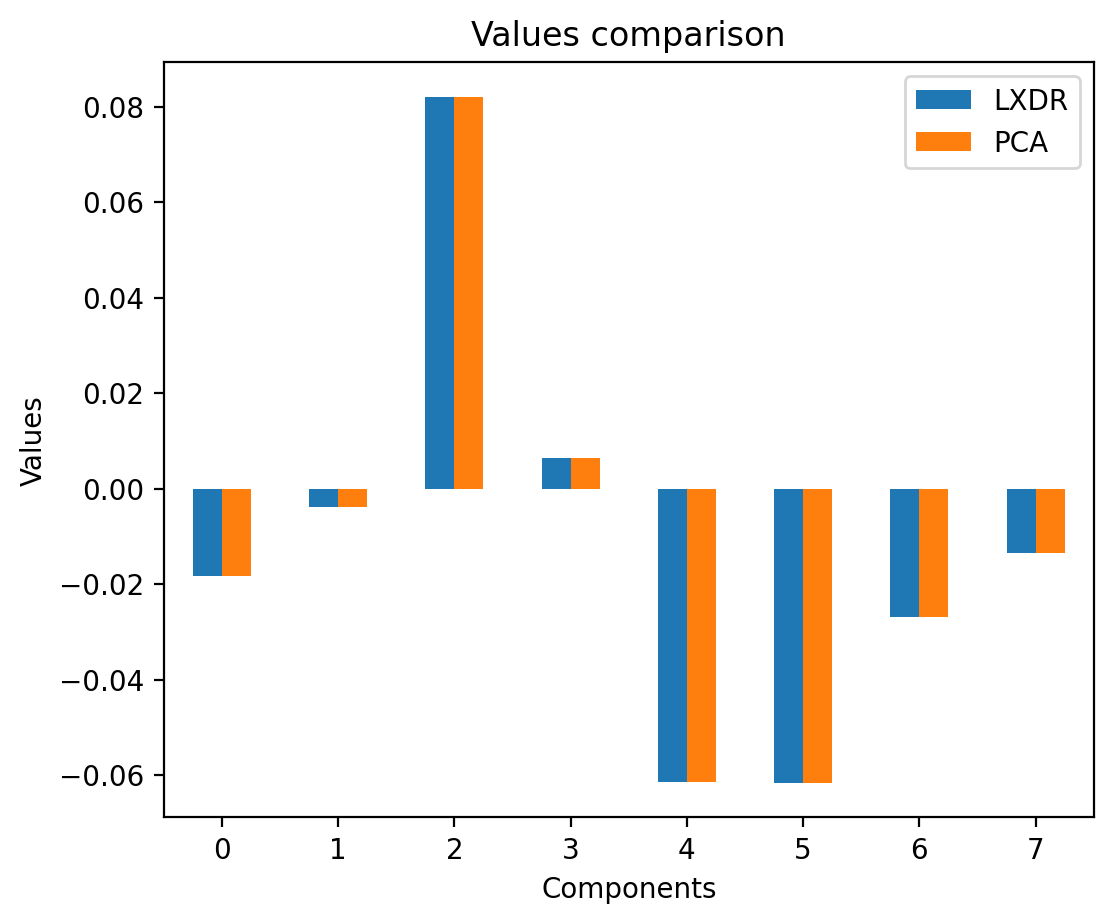

mean_absolute_error =  1.1671401972582055e-06
cosine error =  6.526112983351595e-11
euclidean error =  4.031274275322546e-06


(1.1671401972582055e-06, array([[6.52611298e-11]]), array([[4.03127428e-06]]))

In [11]:
lxdr_obj.visualise_reconstructed(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True)

lxdr_obj.find_reconstruction_error(X_test[1].reshape(1, -1), number_of_neighbours=50, auto_alpha=True, use_LIME=True)